##SLA linear predictability and seasonal vs. non-seasonal variability in ECCOv4

In [2]:
#Loading the objects I'll use
from __future__ import print_function
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from scipy.signal import detrend as det
%matplotlib inline
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap, cm, shiftgrid
import h5py
import gsw
import io
import base64
from IPython.display import HTML

Patrick asked if I could put together a little notebook showing what I've been up to after a chat. This is it. Any comments and feedback much appreciated. Please just scroll to the relative figures/movies. I tried to write things in a transparent manner, and all the code to generate most of this stuff is on display, so anyone wanting to borrow should be able to do so easily. 

So we've computed the seasonal and non-seasonal component of the SLA (ice+snow adjusted), and had a look at fitting an AR process. To adjust I've simply used:
$$\mathrm{SLA} = \mathrm{ETAN}+\frac{load}{\rho},$$

where "load" is the loading from the snow and ice relative to the cell coverage present in the variable "sIceLoad" [In ECCO nctiles: long_name = "sea-ice loading (in Mass of ice+snow / area unit)"], and $\rho$ is set to 1024$kg m^{-3}$. I know this isn't ideal, but I got tired of chasing low-level libraries and will ask Oliver for his version asap.

I'm running on glacier, as my jupyther (the notebooks I use to create things like this...) processes still crash Sill (but it runs in serial as a normal iPython routine).

Just for a sanity check, I'll demonstrate the process I've used to remove the seasonal signal.

In [7]:
#We need to glue together the "faces" of ECCOv4
def getFace(faceNr, field):
    #print x, y
    f =Dataset('/net/harbor/raid6/ecco/ecco_for_las/version_4/release1/nctiles/'+field+'/'+field+'.00{:02d}.nc'.format(faceNr))
    ETAN = f.variables[field][:]
    lat = f.variables['lat'][:]
    lon = f.variables['lon'][:]
    land = f.variables['land'][:]
    return ETAN, lat, lon

def rot90Case((sla, lat, lon)):
    sla=np.fliplr(np.transpose(np.fliplr((sla)), [0,2,1]))
    lon=np.flipud(np.rot90(lon,3))
    lat=np.flipud(np.rot90(lat,3))
    return sla, lat, lon

def fliplrCase((sla, lat, lon)):
    sla=np.fliplr(sla)
    lon=np.flipud(lon)
    lat=np.flipud(lat)
    return sla, lat, lon

def addToMatrix(field_collated, lon_collated, lat_collated, x, y, (sla, lat, lon)):
    field_collated[:,90*x:90*(x+1), 90*y:90*(y+1)]=sla
    lon_collated[90*x:90*(x+1), 90*y:90*(y+1)]=lon
    lat_collated[90*x:90*(x+1), 90*y:90*(y+1)]=lat
    return field_collated, lat_collated, lon_collated

In [8]:
def getField(field):
    field_collated=np.zeros([240,90*4,90*3])
    lon_collated=np.zeros([90*4,90*3])
    lat_collated=np.zeros([90*4,90*3])

    x, y, nr = 3, 2, 4
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 3, 1, 5
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 3, 0, 6
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 0, 2, 1
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 0, 1, 2
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 0, 0, 3
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 1, 0, 11
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 1, 1, 12
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 1, 2, 13
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 2, 0, 8
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 2, 1, 9
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 2, 2, 10
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    return field_collated, lat_collated, lon_collated

In [9]:
sla_collated, lat_collated, lon_collated = getField('ETAN')
ice_collated, lat_collated, lon_collated = getField('sIceLoad')
sla = sla_collated + (ice_collated/1024) 
#NOTE: I will replace 1024 with the actual surface $\rho$ asap. 
#A ballpark check suggested it didn't make a large difference.

In [22]:
#Just to make a figure with a projection that isn't too distorted, we use the Basemap tool. 
#Not all of the horrible syntax is my fault...

def makeFig(data, cMin, cMax, cStep, title, ColMap):
    plt.figure(figsize=(20,12))
    dataPlot=data
    #cMin, cMax, cStep = 0,0.008, 0.0001
    dataIn = sla_collated[2]
    lons = np.roll(np.linspace(0, 360, 360),100)
    lons = lon_collated[:,1]
    dataIn,lons = shiftgrid(lon_collated[0,1],np.flipud(dataIn),lons,start=True, cyclic=360)
    lats = lat_collated[1,:]
    llons, llats = np.meshgrid(lons,lats)
    fig = plt.figure()
    ax = fig.add_axes([0.05,0.05,0.9,0.9])
    # create Basemap instance.
    m = Basemap(projection='kav7',lon_0=10,resolution='l')
    m.drawmapboundary(fill_color='0.9')
    im1 = m.contourf(llons,llats,np.fliplr(np.rot90(dataPlot,3)),np.arange(cMin, cMax, cStep),shading='flat',cmap=ColMap,latlon=True)
    m.drawmapboundary(fill_color='0.9')
    m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[1,1,0,1])
    m.drawcoastlines()
    m.fillcontinents()
    cb = m.colorbar(im1,"bottom", size="5%", pad="9%")
    # add a title.
    ax.set_title(title)
    #plt.savefig('remapMLD_06_ORCA1.png', format='png', dpi=500)
    plt.show()

Having a look at the SLA (below for March 1992), note that the arctic is still missing. I hope this looks reasonable. 

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

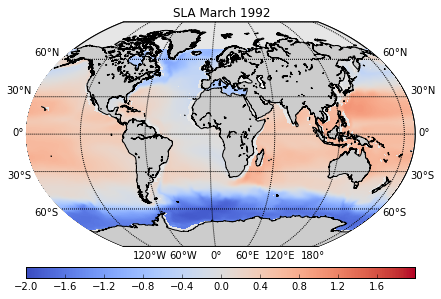

In [24]:
makeFig(sla[2], -2,2, 0.01, 'SLA March 1992', plt.cm.coolwarm)

I ran this on Glacier, but just to demonstrate, I'll pull out the seasonal signal. I hope if I've made a mistake, or I should do something differently, this will become obvious.

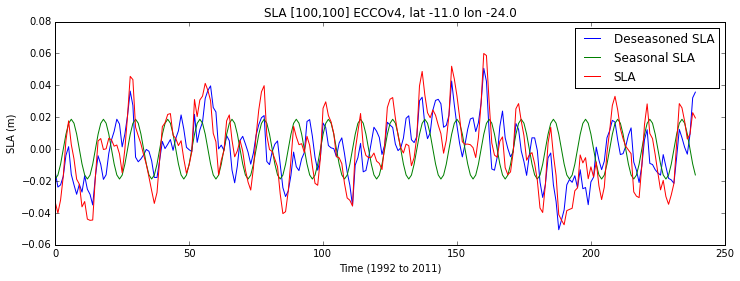

In [104]:
#We make the filters...
fft_filt = np.ones((121), dtype=complex)
fft_filt[20] = 0
a=18;b=19
fft_filt[a:b] = np.linspace(1, 0, len(fft_filt[a:b]))
fft_filt_seas = np.zeros((121), dtype=complex)
fft_filt_seas[20] = 1

#We try to bundle things... Sorry about the awkward variable naming.
def FilterSeasons(data, fft_filt):
    fft_vals1 = np.fft.rfft(data)
    return np.fft.irfft(fft_vals1*fft_filt)

dta = FilterSeasons(det(sla[:,x,y]), fft_filt)
seasonalData1=FilterSeasons(det(sla[:,x,y]), fft_filt_seas)

#Plot the results!
plt.figure(figsize=(12,4))
ts = np.arange(0, 240)
plt.plot(ts, dta, ts, seasonalData1, ts, det(sla[:,x,y]))
plt.xlabel('Time (1992 to 2011)');plt.ylabel('SLA (m)');plt.title('SLA [100,100] ECCOv4, lat {:02} lon {:02}'.format(np.floor(lat_collated[x,y]), np.floor(lon_collated[x,y])))
plt.legend(('Deseasoned SLA', 'Seasonal SLA', 'SLA'))

I thought this looked convincing, but seasonal harmonics are still present. I'm not sure how interesting it would be to chase these though? Thoughts welcome!

We'll move on here to the global fields, looking at the variability contained in the seasonal and non-seasonal components. To get a bit more of a feel for things, I made a little movie. NOTE: SLA is normalised

In [107]:
video = io.open('/data4/maike_s/Documents/ECCO_intro/SLA/sla.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

Just to show the snow+ice loading, I've just added this as well...

In [109]:
video = io.open('/data4/maike_s/Documents/ECCO_intro/SLA/sIceLoad_fast.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

So in the figure below, I've fit an AR(3) to the non-seasonal, detrended, SLA data, and I'm showing the RMS from this from 2009 to 2011. I guess it might largely be noise, but it's interesting that we do see some structures along the path of the Gulf Stream say or areas that by eye look to have larger lateral gradients in SLA, or are associated with larger variance.

In [3]:
#Loading the data:
f = h5py.File('/net/confucius/raid13/home/maike_s/ECCO_SLA/sla_divs_deseasoned_RMS.h5', 'r')
divs = f['sla_pred'][:]
deseasonedData = f['deseasonedData']
f = h5py.File('/net/confucius/raid13/home/maike_s/ECCO_SLA/sla_seasonal.h5', 'r')
seasonalData = f['seasonalDala']

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

/data4/maike_s/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


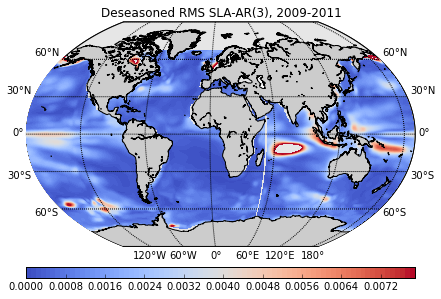

In [10]:
makeFig(divs, 0,0.008, 0.0001, 'Deseasoned RMS SLA-AR(3), 2009-2011', plt.cm.coolwarm)

If we look at the variance associated with the seasonal and non-seasonal parts of the SLA, this is interesting too. For me it's also instructive to look at the ratio between the two.

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

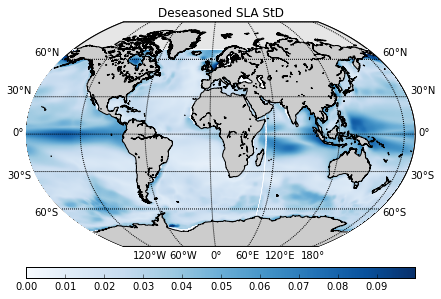

In [27]:
makeFig(np.std(deseasonedData, axis=0), 0,0.1, 0.0001, 'Deseasoned SLA StD', plt.cm.Blues)

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

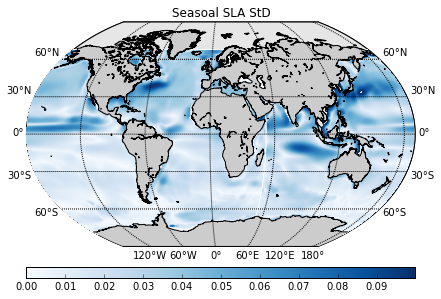

In [26]:
makeFig(np.std(seasonalData, axis=0), 0,0.1, 0.0001, 'Seasoal SLA StD', plt.cm.Blues)

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

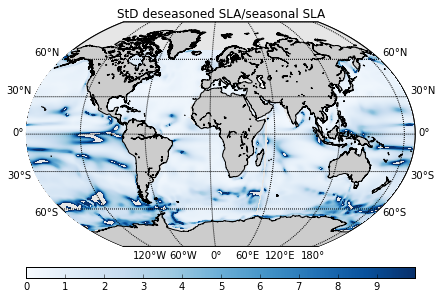

In [30]:
makeFig(np.std(deseasonedData, axis=0)/np.std(seasonalData, axis=0), 0,10, 0.01, 'StD deseasoned SLA/seasonal SLA', plt.cm.Blues)

Looking at the decomposition of the SLA, it seemed that the seasonal signal might still be hanging around. So just to demonstrate, have a look at the two figures below where we look at one point and fit an AR(3), AR(12) and an AR(20). We see that our "skill" increases with the AR(12). At least for a few months? This is the case for both the non-seasonal and full SLA signal.

I'm currently running the global RMS with an AR(12), but it's pretty slow... And I guess it's not terribly interesting, as I'm in effect just fittin the seasonal cycle, but I thought it would be nice to have a look.

/data4/maike_s/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/data4/maike_s/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


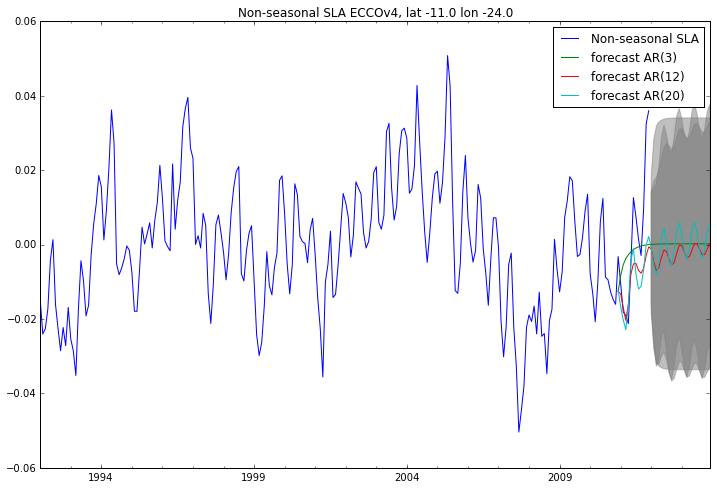

In [115]:
slaFit = det(dta)
rng = pd.date_range('1/1/1992', '12/31/2011', freq='M')
dta_sla = pd.Series(slaFit, index=rng, name='SLA')

arma_mod20 = sm.tsa.ARMA(dta_sla, (20,0)).fit()
arma_mod12 = sm.tsa.ARMA(dta_sla, (12,0)).fit()
arma_mod30 = sm.tsa.ARMA(dta_sla, (3,0)).fit()

fig, ax = plt.subplots(figsize=(12, 8))
ax = dta_sla.ix['1992':].plot(ax=ax)
fig = arma_mod30.plot_predict('2010', '2013', dynamic=True, ax=ax, plot_insample=False)
fig = arma_mod12.plot_predict('2010', '2013', dynamic=True, ax=ax, plot_insample=False)
fig = arma_mod20.plot_predict('2010', '2013', dynamic=True, ax=ax, plot_insample=False)
plt.title('Non-seasonal SLA ECCOv4, lat {:02} lon {:02}'.format(np.floor(lat_collated[x,y]), np.floor(lon_collated[x,y])))
plt.legend(('Non-seasonal SLA', 'forecast AR(3)', 'forecast AR(12)', 'forecast AR(20)'))

/data4/maike_s/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/data4/maike_s/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


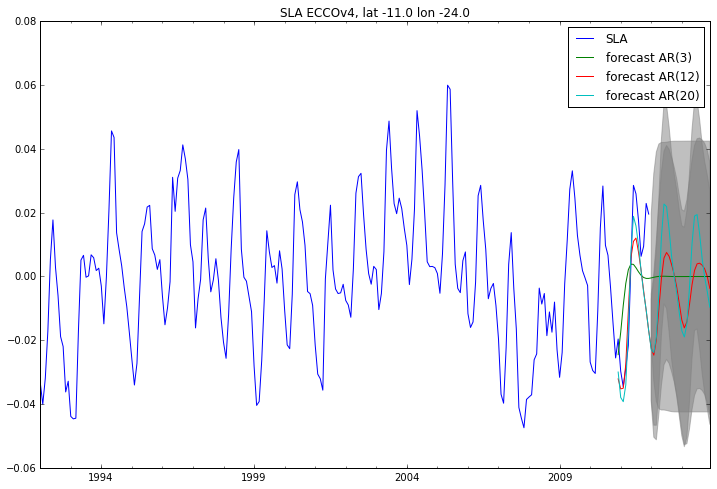

In [76]:
slaFit = det(sla[:,x,y])
rng = pd.date_range('1/1/1992', '12/31/2011', freq='M')
dta_sla = pd.Series(slaFit, index=rng, name='SLA')

arma_mod20 = sm.tsa.ARMA(dta_sla, (20,0)).fit()
arma_mod12 = sm.tsa.ARMA(dta_sla, (12,0)).fit()
arma_mod30 = sm.tsa.ARMA(dta_sla, (3,0)).fit()

fig, ax = plt.subplots(figsize=(12, 8))
ax = dta_sla.ix['1992':].plot(ax=ax)
fig = arma_mod30.plot_predict('2010', '2013', dynamic=True, ax=ax, plot_insample=False)
fig = arma_mod12.plot_predict('2010', '2013', dynamic=True, ax=ax, plot_insample=False)
fig = arma_mod20.plot_predict('2010', '2013', dynamic=True, ax=ax, plot_insample=False)
plt.title('SLA ECCOv4, lat {:02} lon {:02}'.format(np.floor(lat_collated[x,y]), np.floor(lon_collated[x,y])))
plt.legend(('SLA', 'forecast AR(3)', 'forecast AR(12)', 'forecast AR(20)'))

#### Just a quick look at the stats of the non-seasonal fit...

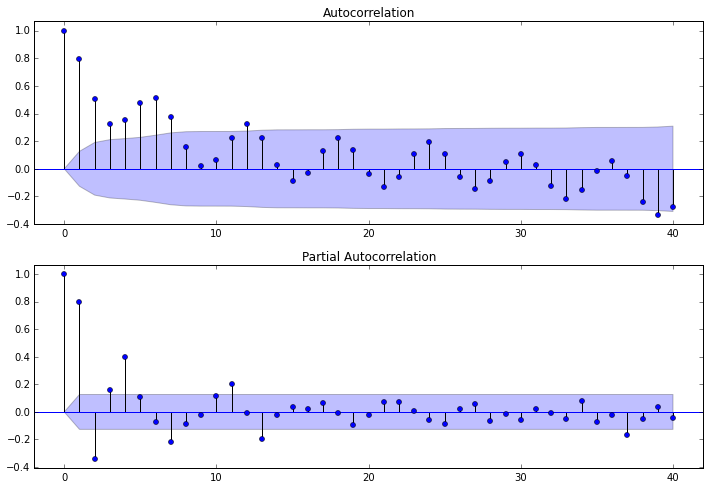

In [118]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta_sla.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta_sla, lags=40, ax=ax2)

In [119]:
print(arma_mod30.params)
print(arma_mod30.aic, arma_mod20.bic, arma_mod20.hqic)
print(arma_mod20.params)
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)
print(arma_mod12.params)
print(arma_mod12.aic, arma_mod30.bic, arma_mod30.hqic)


const        0.000212
ar.L1.SLA    1.137271
ar.L2.SLA   -0.511939
ar.L3.SLA    0.152509
dtype: float64
-1543.24602456 -1530.49403036 -1576.21433249
const         0.000372
ar.L1.SLA     0.952101
ar.L2.SLA    -0.047530
ar.L3.SLA    -0.218277
ar.L4.SLA     0.180026
ar.L5.SLA     0.071209
ar.L6.SLA     0.020783
ar.L7.SLA    -0.082799
ar.L8.SLA     0.020362
ar.L9.SLA    -0.092426
ar.L10.SLA   -0.098380
ar.L11.SLA    0.170648
ar.L12.SLA    0.180760
ar.L13.SLA   -0.169725
ar.L14.SLA   -0.093812
ar.L15.SLA    0.065349
ar.L16.SLA   -0.024812
ar.L17.SLA    0.067070
ar.L18.SLA    0.034372
ar.L19.SLA   -0.062138
ar.L20.SLA   -0.014211
dtype: float64
-1607.06808667 -1530.49403036 -1576.21433249
const        -0.000107
ar.L1.SLA     0.965503
ar.L2.SLA    -0.120822
ar.L3.SLA    -0.216396
ar.L4.SLA     0.232263
ar.L5.SLA     0.095976
ar.L6.SLA     0.051138
ar.L7.SLA    -0.118814
ar.L8.SLA    -0.023247
ar.L9.SLA    -0.134955
ar.L10.SLA   -0.050021
ar.L11.SLA    0.229847
ar.L12.SLA   -0.025472
dtype: flo

But are the data independent? The Durbin-Watson statistic is a test statistic used to detect the presence of autocorrelation... Let's check!

(Liberally hacked together from Wikipedia...)If et is the residual associated with the observation at time t, then the test statistic is
$$d = {\sum_{t=2}^T (e_t - e_{t-1})^2 \over {\sum_{t=1}^T e_t^2}},$$

where T is the number of observations. Note that if one has a lengthy sample, then Statistical Ideas site shows this can be linearly mapped to the Pearson correlation of the time-series data with its lags. Since d is approximately equal to 2(1 − r), where r is the sample autocorrelation of the residuals,[3] d = 2 indicates no autocorrelation. The value of d always lies between 0 and 4. If the Durbin–Watson statistic is substantially less than 2, there is evidence of positive serial correlation. As a rough rule of thumb, if Durbin–Watson is less than 1.0, there may be cause for alarm. Small values of d indicate successive error terms are, on average, close in value to one another, or positively correlated. If d > 2, successive error terms are, on average, much different in value from one another, i.e., negatively correlated. In regressions, this can imply an underestimation of the level of statistical significance.

In [123]:
print(sm.stats.durbin_watson(arma_mod20.resid.values), sm.stats.durbin_watson(arma_mod12.resid.values), sm.stats.durbin_watson(arma_mod30.resid.values))
print('In conclusion: We are still good! (Because it is less than 1)')

1.96678870443 1.97610776582 2.10059139446
In conclusion: We are still good! (Because it is less than 1)


It makes sense to have a look at the residuals. We're still looking at the non-seasonal data here. However, by eye, I certainly can't tell much difference in the plot below...

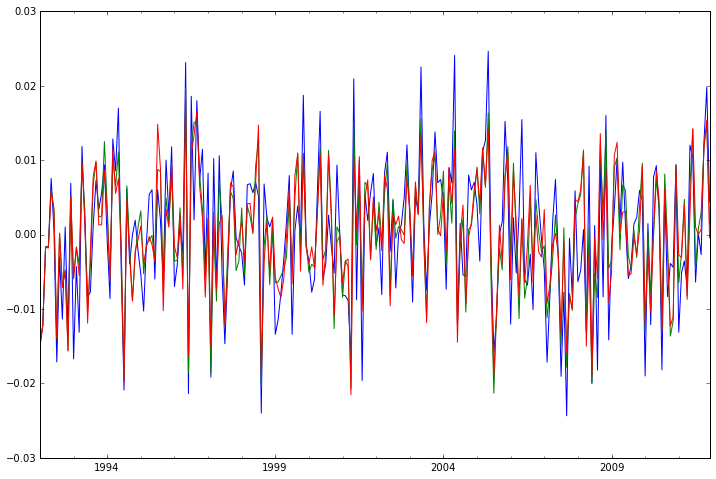

In [124]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_mod30.resid.plot(ax=ax)
ax = arma_mod12.resid.plot(ax=ax)
ax = arma_mod20.resid.plot(ax=ax)

Mod3 z test (skewness) and the 2-sided chi squared probability (p value)
 NormaltestResult(statistic=0.23400054016584851, pvalue=0.8895849529016735)
Mod2 z test (skewness) and the 2-sided chi squared probability (p value)
 NormaltestResult(statistic=3.1619283605195605, pvalue=0.20577659679213781)
Mod2 z test (skewness) and the 2-sided chi squared probability (p value)
 NormaltestResult(statistic=2.8774890620824762, pvalue=0.23722540092982222)


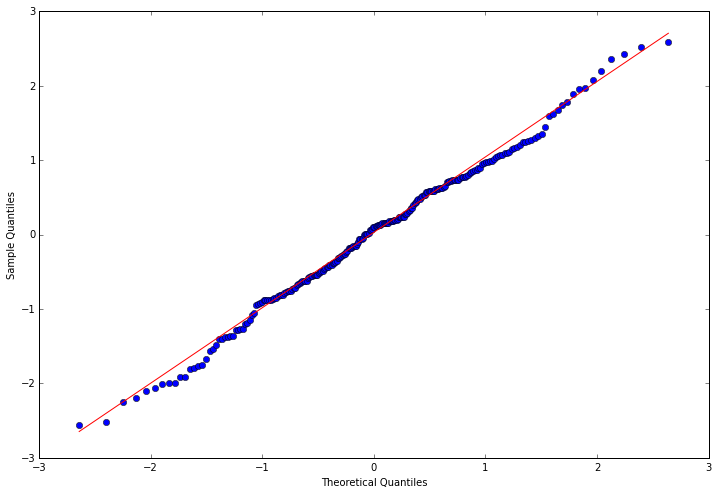

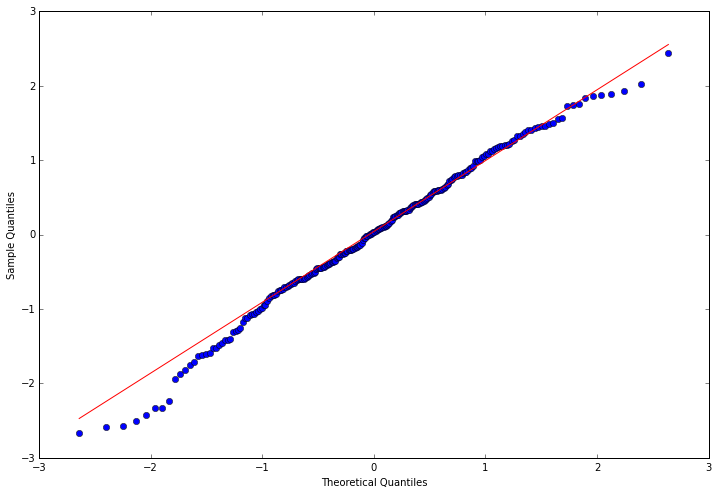

In [126]:
resid3 = arma_mod30.resid
print('Mod3 z test (skewness) and the 2-sided chi squared probability (p value)\n', stats.normaltest(resid3))
resid12 = arma_mod12.resid
print('Mod2 z test (skewness) and the 2-sided chi squared probability (p value)\n',stats.normaltest(resid12))
resid20 = arma_mod20.resid
print('Mod2 z test (skewness) and the 2-sided chi squared probability (p value)\n',stats.normaltest(resid20))


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid3, line='q', ax=ax, fit=True)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid12, line='q', ax=ax, fit=True)

So we see that the QQ plots show that the AR(12) is more heavy-tailed than the AR(3). So the more the points follow the line, the more "normal" they are, which is bad news for predictability, because we're fitting a random process in that case.

Anyway, this is just a little demo. I looked at the auto-correlation of the residuals as well, but I'd actually be impressed if anyone I send this to makes it this far :)